# **GPU로 실행해 주세요**



# **서술형**


**Q1. CLIP 모델의 contrastive learning 구조를 간략하게 설명해 주세요.**




A1. 올바른 이미지 쌍은 가깝게, 다른 이미지 쌍은 멀리 학습하는 구조로, 코사인 유사도를 활용한다. 잘못된 쌍에 대해 코사인 유사도를 최소화하는 방식을 통해 올바른 쌍을 더 잘 인식할 수 있도록 하는 구조이다.

**Q2. CLIP 모델의 contrastive learning을 supervised learning과 비교해 주세요.**

A2. supervised learning은 정해진 라벨로 분류하며 학습하는 것이다. 예를들어 고양이를 1로, 강아지를 0으로 분류하는 것에 해당한다. 반면에, contrastive learning은 특정 라벨로 분류하는 것이 아닌, 고양이 이미지 - 고양이 텍스트 이렇게 쌍으로 비슷한 의미는 가까이, 다른 의미는 멀리 학습한다.

# **코드**

## **라이브러리 임포트**

In [1]:
!pip install -qq datasets

In [2]:
import os
import torch
import random
from random import sample

from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset

from transformers import CLIPProcessor, CLIPModel

from tqdm import tqdm

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
device # device(type='cuda')로 출력되는지 확인

device(type='cuda')

## **Dataset 다운로드**

**Dataset**
- Dataset은 총 2000장의 과일 이미지(train 1600, test 400)와 각 이미지에 매핑된 라벨(사과, 배, 바나나, 체리)로 구성되어 있습니다.

In [5]:
!wget -qq 'https://www.dropbox.com/scl/fi/mf806inzv0x6abbb2su0k/fruit-dataset.zip?rlkey=gk7s9d14m6k9o1ru4whrgtwke&dl=1' -O data.zip
!unzip -qq data.zip -d fruit-dataset/
!echo "Number of Images : $(find ./fruit-dataset -type f | wc -l)"

Number of Images : 2000


In [6]:
dataset = load_dataset("./fruit-dataset")

print(dataset)

class_map = { k:v for k, v in enumerate(dataset['train'].features['label'].names) }
class_names = [v for k,v in class_map.items()]
print(class_map)
print(class_names)

Resolving data files:   0%|          | 0/1600 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/400 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1600
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 400
    })
})
{0: 'apple', 1: 'asian pear', 2: 'banana', 3: 'cherry'}
['apple', 'asian pear', 'banana', 'cherry']


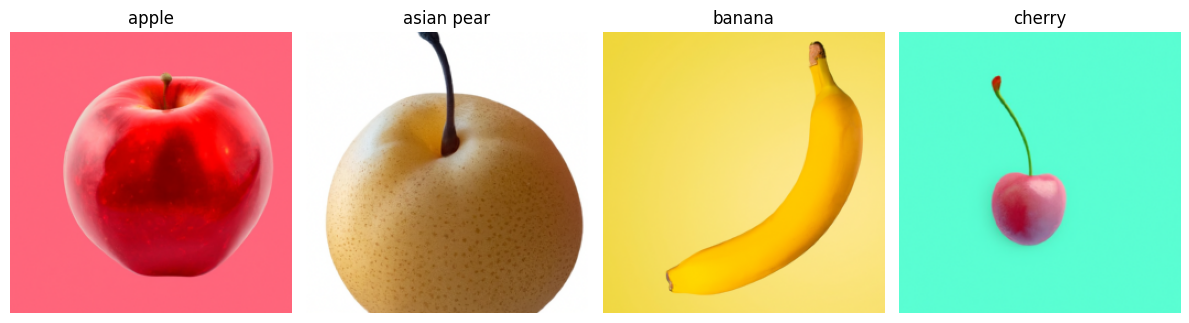

In [7]:
samples = []
for class_id, class_name in class_map.items():
    indices = [i for i, label in enumerate(dataset['train']['label']) if label == class_id]
    idx = random.choice(indices)
    samples.append((dataset['train'][idx]['image'], class_name))

fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for ax, (img, label) in zip(axes, samples):
    ax.imshow(img)
    ax.set_title(label)
    ax.axis("off")

plt.tight_layout()
plt.show()

## **모델 로드**

**CLIP**
- CLIP은 이미지와 텍스트를 같은 임베딩 공간으로 변환한 뒤, 둘 사이의 유사도를 계산해 가장 잘 맞는 쌍을 찾아내는 모델입니다.

  CLIP은 하나의 이미지를 입력으로 주고 여러 개의 텍스트 프롬프트를 준비해 두면, 이미지 임베딩과 각 텍스트 임베딩의 유사도를 계산합니다. 그리고 가장 유사한 텍스트 프롬프트를 선택함으로써, 이미지를 해당 클래스에 할당할 수 있습니다.

  텍스트를 입력으로 주고, 데이터셋에 있는 여러 이미지와 비교하는 것도 가능합니다. CLIP은 텍스트 임베딩과 모든 이미지 임베딩의 유사도를 계산한 뒤, 입력 텍스트와 가장 가까운 이미지를 반환합니다. 예를 들어 “a photo of a cat”이라는 텍스트를 주면, 고양이 이미지들이 높은 점수를 받아 결과로 나오게 됩니다.

  정리하자면, CLIP은 이미지와 텍스트를 공통 임베딩 공간에서 직접 연결해 주기 때문에, 텍스트와 이미지 간의 매칭을 유연하게 수행할 수 있습니다.

- https://github.com/openai/CLIP/blob/main/README.md

In [8]:
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

## **필요한 함수 정의**

**classify_image()**
- 이미지와 텍스트 프롬프트들을 입력으로 받아, 이미지와 가장 잘 일치하는 텍스트 프롬프트의 인덱스와 각 프롬프트에 대한 확률을 반환하는 함수

In [9]:
def classify_image(image, align_texts):
    if isinstance(image, str) and os.path.isfile(image):
        image = Image.open(image)
    elif not isinstance(image, Image.Image):
        raise ValueError("The provided image must be a PIL Image or a file path to an image.")

    inputs = processor(text=align_texts, images=image, return_tensors="pt", padding=True)

    tokenized_text = inputs['input_ids']

    decoded_text = [processor.tokenizer.decode(ids) for ids in tokenized_text]

    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs) # 모델 추론
        logits_per_image = outputs.logits_per_image  # 이미지 ↔ 텍스트 간 similarity score 행렬
        probs = logits_per_image.softmax(dim=1) # 확률로 변환
        pred_text_idx = torch.argmax(probs, dim=1) # 가장 높은 확률의 텍스트 인덱스 선택

    return pred_text_idx.item(), decoded_text, probs

**get_n_qeury_texts(class_name, N)**
- query_templates에서 앞의 N개를 골라 {image}에 class_name을 넣어 N개의 문장을 만드는 함수
- e.g. class_name="apple", N=3 →
["This is an image of a apple.", "A photo of a apple.", "You are looking at a apple."]


In [10]:
query_templates = [
    "This is an image of a {image}.",
    "Here we see a {image}.",
    "The photo depicts a {image}.",
    "In this picture, there is a {image}.",
    "This picture shows a {image}.",
    "A {image} is present in this image.",
    "You can see a {image} here.",
    "This image represents a {image}.",
    "A {image} is captured in this shot.",
    "The object in this image is a {image}."
]

In [11]:
def _a_or_an(word: str) -> str:
    return f"an {word}" if word[0].lower() in "aeiou" else f"a {word}"

def get_n_query_texts(class_name, N):
    np_word = _a_or_an(class_name)
    texts = []
    for t in query_templates[:N]:
        txt = t.format(image=class_name, np=np_word)
        if " a " + class_name in txt and np_word.startswith("an "):
            txt = txt.replace(" a " + class_name, " an " + class_name)
        if " A " + class_name in txt and np_word.startswith("an "):
            txt = txt.replace(" A " + class_name, " An " + class_name)
        texts.append(txt)
    return texts

**make_query_texts(class_names, N)**
- (class, 생성한 문장) 형태의 튜플을 만들고 이 튜플들을 모아 하나의 리스트 class_and_texts_map으로 반환하는 함수

In [12]:
def make_query_texts(class_names, N):
    class_and_texts_map = []
    for cls in class_names:
        query_texts = get_n_query_texts(cls, N)
        class_and_texts_map.extend((cls, q) for q in query_texts)
    return class_and_texts_map

**do_prompt_based_image_classification(image_path, N=1)**
  - 각 클래스 이름으로 N개의 템플릿 문장을 만들고, (make_query_texts() 호출)
    
    이미지와 모든 문장 간 유사도를 모델로 계산한 뒤, (classify_image() 호출)

    문장별 확률을 클래스별로 평균내어 최종 클래스를 예측하는 함수

  - 예시
    - 다음과 같이 2개의 class가 있다고 가정해 봅시다.
      - ["cat", "dog"]
    - query template을 이용해 클래스별로 2개 문장을 생성했다고 가정해 봅시다.
      - cat-query-prompt1: "This is an image of a cat."
      - cat-query-prompt2: "A photo of a cat."
      - dog-query-prompt1: "This is an image of a dog."
      - dog-query-prompt2: "A photo of a dog."
    - cat 이미지를 넣었을 때, 모델이 모든 문장에 대해 계산한 similarity가 아래와 같다고 가정해 봅시다.
      - cat-query-prompt1: 0.40
      - cat-query-prompt2: 0.35
      - dog-query-prompt1: 0.05
      - dog-query-prompt2: 0.20
    - 이 함수에서는 클래스별로 문장들을 묶어서 클래스별 확률을 계산합니다.
      - cat 클래스 확률: (0.40 + 0.35) / 2
      - dog 클래스 확률: (0.05 + 0.20) / 2
    - 클래스별 확률을 비교하고 최종 예측 클래스를 결정합니다.
      - cat((0.40 + 0.35) / 2) > dog((0.05 + 0.20) / 2)  
      - 최종 예측 클래스: cat


In [13]:
def do_prompt_based_image_classification(image_path, N=1):
    N = max(1, min(N, len(query_templates)))

    class_and_texts_map = make_query_texts(class_names, N) # (class, 생성한 문장) 형태의 튜플 리스트
    query_texts = [x[1] for x in class_and_texts_map]      # 문장 부분만 추출

    best_idx, actual_query_texts, probs = classify_image(image_path, query_texts)  # 이미지와 모든 문장 간 유사도를 계산

    probs_1d = probs[0]
    class_to_vals = {}
    for i, (cls, _) in enumerate(class_and_texts_map):
        class_to_vals.setdefault(cls, []).append(probs_1d[i].item())
    class_probs = {cls: sum(v)/len(v) for cls, v in class_to_vals.items()} # 문장별 확률을 클래스별로 묶어서 계산

    predicted_class = max(class_probs.items(), key=lambda x: x[1])[0]      # 클래스별 평균 확률 중 가장 높은 것을 최종 예측 클래스(predicted_class)로 선택

    best_text = class_and_texts_map[best_idx][1] # 문장 단위에서 가장 높은 확률을 보인 문장(best_text)과
    best_text_prob = probs_1d[best_idx].item()   # 그 확률(best_text_prob)도 따로 저장

    return {
        "predicted_class": predicted_class,
        "class_probs": class_probs,               # 클래스별 평균 확률
        "best_text_idx": best_idx,                # 최고 점수 문장의 인덱스
        "best_text": best_text,                   # 최고 점수 문장
        "best_text_prob": best_text_prob,         # 그 문장의 확률
        "actual_query_texts": actual_query_texts, # 토큰 복원된 문장들
        "class_and_texts_map": class_and_texts_map
    }

## **모델 예측** - 이미지 한 장

예측하려는 이미지는 다음과 같습니다.

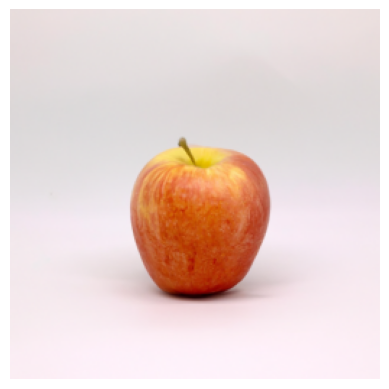

In [14]:
image_path = "./fruit-dataset/test/apple/apple_428.png"

img = Image.open(image_path)

plt.imshow(img)
plt.axis("off")
plt.show()

In [15]:
result = do_prompt_based_image_classification(image_path, N=1)

In [16]:
for key, value in result.items():
    print(f"{key}: {value}")

predicted_class: apple
class_probs: {'apple': 0.9281210899353027, 'asian pear': 0.017083967104554176, 'banana': 0.0002611094678286463, 'cherry': 0.05453382804989815}
best_text_idx: 0
best_text: This is an image of an apple.
best_text_prob: 0.9281210899353027
actual_query_texts: ['<|startoftext|>this is an image of an apple . <|endoftext|><|endoftext|>', '<|startoftext|>this is an image of an asian pear . <|endoftext|>', '<|startoftext|>this is an image of a banana . <|endoftext|><|endoftext|>', '<|startoftext|>this is an image of a cherry . <|endoftext|><|endoftext|>']
class_and_texts_map: [('apple', 'This is an image of an apple.'), ('asian pear', 'This is an image of an asian pear.'), ('banana', 'This is an image of a banana.'), ('cherry', 'This is an image of a cherry.')]


### **결과 분석**

**Q. 모델이 최종적으로 예측한 클래스는 무엇이고 그 확률은 몇인가요?**

A. apple. 0.9281

## **모델 예측** - test dataset



### **실험 1 (N=1)**
  - do_prompt_based_image_classification(image, N=1) 함수를 호출하는 부분에서 N=1임에 주목해 주세요.
   - N은 사용할 프롬프트 개수를 의미했습니다.
   - 즉, 여기서는 각 클래스마다 *하나의 프롬프트*만 사용하여 분류를 진행합니다.

In [17]:
true_labels = []
predicted_labels = []

r_class_map = {v: k for k, v in class_map.items()}

num_samples = 200  # 샘플 200개만 사용하여 예측
random_indices = sample(range(len(dataset['test'])), num_samples)

for item in tqdm(dataset['test'].select(random_indices)):
    image = item['image']
    true_label = item['label']
    true_labels.append(true_label)

    result = do_prompt_based_image_classification(image, N=1)

    pred_class_label = result["predicted_class"]

    predicted_labels.append(r_class_map[pred_class_label])

100%|██████████| 200/200 [00:10<00:00, 18.61it/s]


Accuracy: 0.9700
Precision: 0.9720
Recall: 0.9700
F1-score: 0.9700


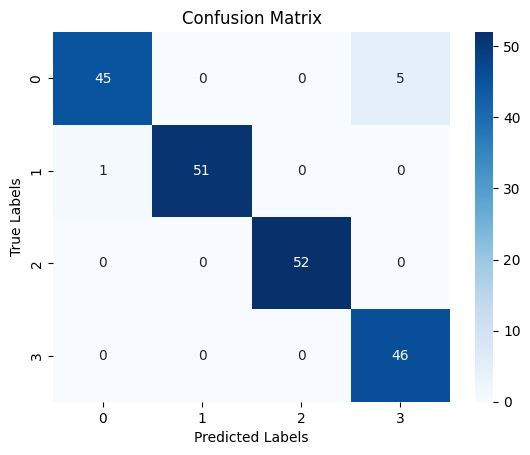

In [18]:
accuracy = accuracy_score(true_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

cm = confusion_matrix(true_labels, predicted_labels)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### **실험 2 (N=2)**

- do_prompt_based_image_classification(image, N=10) 함수를 호출하는 부분에서 N=10임에 주목해 주세요.
- N은 사용할 프롬프트 개수를 의미했습니다.
- 즉, 여기서는 각 클래스마다 *10개의 프롬프트*를 사용하여 분류를 진행합니다.

In [19]:
true_labels = []
predicted_labels = []

r_class_map = {v: k for k, v in class_map.items()}

num_samples = 200  # 샘플 200개만 사용하여 예측
random_indices = sample(range(len(dataset['test'])), num_samples)

for item in tqdm(dataset['test'].select(random_indices)):
    image = item['image']
    true_label = item['label']
    true_labels.append(true_label)

    result = do_prompt_based_image_classification(image, N=10)

    pred_class_label = result["predicted_class"]

    predicted_labels.append(r_class_map[pred_class_label])

100%|██████████| 200/200 [00:06<00:00, 29.64it/s]


Accuracy: 0.9450
Precision: 0.9491
Recall: 0.9450
F1-score: 0.9445


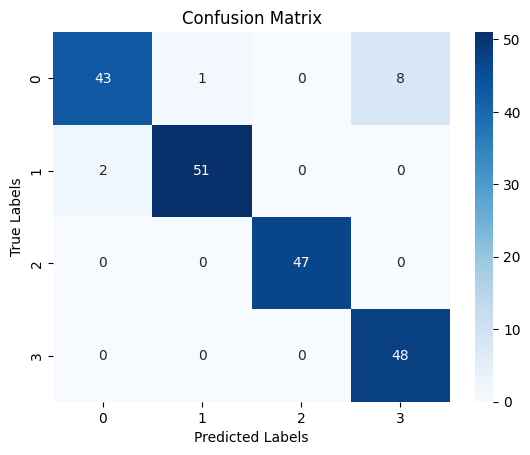

In [20]:
accuracy = accuracy_score(true_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

cm = confusion_matrix(true_labels, predicted_labels)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### **결과 분석**

**Q. N=1일 때와 N=10일 때의 결과를 비교해 주세요.**




A.
N=1일때,
Accuracy: 0.9700
Precision: 0.9720
Recall: 0.9700
F1-score: 0.9700

N=10일때,
Accuracy: 0.9450
Precision: 0.9491
Recall: 0.9450
F1-score: 0.9445

모든 지표들이, N=1일때가 더 좋다.


**Q. N=10일 때의 F1-score가 N=1일 때의 F1-score보다 높다면, 그 이유는 무엇일까요?**


A. 이미지와 의미상 일치하는 프롬프트를 선택할 가능성이 높아져 FN이 상승하고, 잘못된 프롬프트를 선택할 가능성 FP가 줄어들어 균형이 개선돼, F1-score가 높아지기 때문이다.